In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
# from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Activation, LeakyReLU, Dropout, BatchNormalization, MaxPooling2D, Lambda
from keras.models import Model
from sklearn.metrics import mean_squared_error as mse
from progressbar import ProgressBar
from image_process import ImageProcess
import const, cv2
from drive_data import DriveData
from config import Config

import matplotlib.pyplot as plt
import sys
sys.setrecursionlimit(10**7)
tf.compat.v1.disable_eager_execution()

               Configuration Settings
Neural Net:     	fusion_kdh_jaerock3
Data Collection:	fusion_kdh_jaerock3
Run Neural:     	fusion_kdh_jaerock3




In [2]:
"""
## Dataset
"""
image_process = ImageProcess()
config = Config.neural_net
# data_path = "/mnt/exData/internal_simulation/test/2022-03-08-17-18-14/"
data_path = "/home2/kdh/vae/2022-12-08-14-25-28/"
if data_path[-1] == '/':
    data_path = data_path[:-1]

    loc_slash = data_path.rfind('/')
    if loc_slash != -1: # there is '/' in the data path
        model_name = data_path[loc_slash + 1:] # get folder name
        #model_name = model_name.strip('/')
    else:
        model_name = data_path
csv_path = data_path + '/' + model_name + const.DATA_EXT 
# data = DriveData(csv_path)
print(csv_path)
# data_path = data_path
# data.read()

csv_header = ['image_fname', 
                  'steering_angle', 'throttle', 'brake', 'linux_time', 
                  'vel', 'vel_x', 'vel_y', 'vel_z', 
                  'pos_x', 'pos_y', 'pos_z', 
                  'tar_image_fname', 'tar_steering_angle', 'tar_vel', 'tar_time']

df = pd.read_csv(csv_path, names=csv_header, index_col=False)
num_data = len(df)

bar = ProgressBar()
df_image_names = []
df_measurements = []
df_time_stamps= []
df_velocities= []
df_velocities_xyz= []
df_positions_xyz= []
df_tar_image_names= []
df_tar_steering_angle= []
df_tar_vel= []
df_tar_time= []
for i in bar(range(num_data)): # we don't have a title
    df_image_names.append(df.loc[i]['image_fname'])
    # if Config.data_collection['brake'] is True:
    df_measurements.append((float(df.loc[i]['steering_angle']),
                            float(df.loc[i]['throttle']), 
                            float(df.loc[i]['brake'])))
    df_time_stamps.append(float(df.loc[i]['linux_time']))
    df_velocities.append(float(df.loc[i]['vel']))
    df_velocities_xyz.append((float(df.loc[i]['vel_x']), 
                                float(df.loc[i]['vel_y']), 
                                float(df.loc[i]['vel_z'])))
    df_positions_xyz.append((float(df.loc[i]['pos_x']), 
                                float(df.loc[i]['pos_y']), 
                                float(df.loc[i]['pos_z'])))
    df_tar_image_names.append(df.loc[i]['tar_image_fname'])
    df_tar_steering_angle.append(float(df.loc[i]['tar_steering_angle']))
    df_tar_vel.append(float(df.loc[i]['tar_vel']))
    df_tar_time.append(float(df.loc[i]['tar_time']))

/home2/kdh/vae/2022-12-08-14-25-28/2022-12-08-14-25-28.csv


100% |########################################################################|


In [3]:
samples = list(zip( df_image_names, df_velocities, df_measurements, 
                    df_tar_image_names, df_tar_steering_angle, df_tar_vel, df_tar_time))

In [4]:
def prepare_vae_batch_samples(batch_samples):
    images = []
    steering_angles = []
    vels = []
    tar_images = []
    tar_steering_angles = []
    tar_vels = []
    tar_times = []
        
    for image_name, velocity, measurement, tar_image_name, tar_steering_angle, tar_vel, tar_time in batch_samples:
        # self.data.image_names, self.data.velocities, self.data.measurements, 
        # self.data.tar_image_names, self.data.tar_steering_angle, self.data.tar_vel, self.data.tar_time
        
        image_path = data_path + '/' + image_name
        # print(data_path, tar_image_name)
        tar_image_path = data_path + '/' + tar_image_name
        image = cv2.imread(image_path)
        tar_image = cv2.imread(tar_image_path)

        # if collected data is not cropped then crop here
        # otherwise do not crop.
        if Config.data_collection['crop'] is not True:
            image = image[Config.data_collection['image_crop_y1']:Config.data_collection['image_crop_y2'],
                        Config.data_collection['image_crop_x1']:Config.data_collection['image_crop_x2']]
            tar_image = tar_image[Config.data_collection['image_crop_y1']:Config.data_collection['image_crop_y2'],
                        Config.data_collection['image_crop_x1']:Config.data_collection['image_crop_x2']]
        image = cv2.resize(image, 
                            (config['input_image_width'],
                            config['input_image_height']))
        tar_image = cv2.resize(tar_image, 
                            (config['input_image_width'],
                            config['input_image_height']))
        image = image_process.process(image)
        tar_image = image_process.process(tar_image)

        vels.append(tar_vels)
        tar_vels.append(tar_vel)
        tar_times.append(tar_time)
        tar_steering_angles.append(tar_steering_angle)
        # if no brake data in collected data, brake values are dummy
        steering_angle, throttle, brake = measurement
        steering_angles.append(steering_angle)
        # cv2.imwrite('/home2/kdh/vae/oscar/test/image/'+image_name, image)
        # cv2.imwrite('/home2/kdh/vae/oscar/test/tar_image/'+tar_image_name, tar_image)
        # if data == 'train':
        #     cv2.imwrite('/mnt/Data/oscar/train_data/'+image_name, image)
        # print(image.shape)
        images.append(image)
        tar_images.append(tar_image)
        # segimgs.append(segimg)


    return images, vels, steering_angles, tar_images, tar_steering_angles, tar_vels, tar_times


In [5]:
"""
## Encoder
"""

"""
## Create a sampling layer
"""
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


encoder_inputs_img = tf.keras.Input(shape=(160, 160, 3))
encoder_inputs_str = tf.keras.Input(shape=(1))
encoder_inputs_vel = tf.keras.Input(shape=(1))
encoder_inputs_time = tf.keras.Input(shape=(1))
x = layers.Conv2D(24, (5, 5), padding='same', name='conv2d_1')(encoder_inputs_img)
x = layers.BatchNormalization()(x)
x = layers.Activation('elu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2), name='pool2d_1')(x)

x = layers.Conv2D(36, (5, 5), padding='same', name='conv2d_2')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('elu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2), name='pool2d_2')(x)

x = layers.Conv2D(48, (5, 5), padding='same', name='conv2d_3')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('elu')(x)

x = layers.Conv2D(64, (3, 3), padding='same', name='conv2d_4')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('elu')(x)

x = layers.Conv2D(64, (3, 3), padding='same', name='conv2d_5')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('elu')(x)

latent = layers.Flatten()(x)
fc_s1  = layers.Dense(100)(encoder_inputs_str)
fc_s1  = layers.Activation('elu')(fc_s1)
fc_s2  = layers.Dense(50)(fc_s1)
fc_s2  = layers.Activation('elu')(fc_s2)
fc_v1  = layers.Dense(100)(encoder_inputs_vel)
fc_v1  = layers.Activation('elu')(fc_v1)
fc_v2  = layers.Dense(50)(fc_v1)
fc_v2  = layers.Activation('elu')(fc_v2)
fc_t1  = layers.Dense(100)(encoder_inputs_time)
fc_t1  = layers.Activation('elu')(fc_t1)
fc_t2  = layers.Dense(50)(fc_t1)
fc_t2  = layers.Activation('elu')(fc_t2)
conc_1 = layers.concatenate([latent, fc_s2, fc_v2, fc_t2])
fc_1   = layers.Dense(100)(conc_1)
x   = layers.Activation('elu')(fc_1)

z_mean = layers.Dense(100, name="z_mean")(x)
z_log_var = layers.Dense(100, name="z_log_var")(x)
encoder_output = Sampling()([z_mean, z_log_var])
encoder = tf.keras.Model([ encoder_inputs_img, encoder_inputs_str,
                        encoder_inputs_vel, encoder_inputs_time], 
                        [z_mean, z_log_var, encoder_output], 
                        name="encoder")
encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 160, 160, 24) 1824        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 160, 160, 24) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 160, 160, 24) 0           batch_normalization[0][0]        
____________________

In [176]:
"""
## Decoder
"""

latent_inputs = tf.keras.Input(shape=(100,))
x = layers.Dense(100, activation="elu")(latent_inputs)
x = layers.Dense(40 * 40 * 64, activation="elu")(x)
x = layers.Reshape((40, 40, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="elu",  padding="same")(x)
x = layers.Conv2DTranspose(48, 3, activation="elu",  padding="same")(x)
x = layers.Conv2DTranspose(36, 3, activation="elu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(24, 3, activation="elu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_13 (Dense)             (None, 102400)            10342400  
_________________________________________________________________
reshape_3 (Reshape)          (None, 40, 40, 64)        0         
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 40, 40, 64)        36928     
_________________________________________________________________
conv2d_transpose_14 (Conv2DT (None, 40, 40, 48)        27696     
_________________________________________________________________
conv2d_transpose_15 (Conv2DT (None, 80, 80, 36)        1558

In [7]:
"""
## VAE
"""
model_input = [ encoder_inputs_img, encoder_inputs_str,
                        encoder_inputs_vel, encoder_inputs_time]
model_output = decoder(encoder_output)

VarAE=Model(model_input, model_output)
# VarAE.run_eagerly = True


In [8]:
"""
Data generator
"""
from sklearn.model_selection import train_test_split

def _generator(samples, batch_size=config['batch_size']):
    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        for offset in range(0, (num_samples//batch_size)*batch_size, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images, vels, steering_angles, tar_images, tar_steering_angles, tar_vels, tar_times = prepare_vae_batch_samples(batch_samples)

            X_img = np.array(images).astype("float32")/255.0
            X_tvel = np.array(tar_vels).astype("float32")/15.0
            X_tstr = np.array(tar_steering_angles)*config['steering_angle_scale']
            X_ttime = np.array(tar_times)*config['time_scale']

            y_train = np.array(tar_images).astype("float32")/255.0
            # if config['num_outputs'] == 1:
            # y_train = np.array(segimg)
            # print(y_train.max())
            # y_train = np.repeat(y_train[..., np.newaxis], 1, -1)/y_train.max()
            X_train = [X_img, X_tstr, X_tvel, X_ttime]
            # print(y_train)
            # print(y_train.shape)
            yield X_train, y_train

train_data, valid_data = train_test_split(samples, test_size=config['validation_rate'])

train_generator = _generator(train_data, config['batch_size'])
valid_generator = _generator(valid_data, config['batch_size'])    


In [26]:
"""
VAE loss
"""
optimizer=tf.keras.optimizers.Adam(learning_rate=0.000005, decay=0.0000000001)
r_loss_factor=160*160*100   # This is a Hyperparameter

def vae_r_loss(y_true, y_pred):    ## MSE
    r_loss = tf.keras.backend.mean(tf.keras.backend.square(y_true-y_pred), axis=[1,2,3])
    return r_loss_factor * r_loss

def vae_kl_loss(y_true, y_pred):   ## KL-Divergence
    kl_loss=( -0.5 * tf.keras.backend.sum(1+z_log_var 
                - tf.keras.backend.square(z_mean) 
                - tf.keras.backend.exp(z_log_var), axis=1)
    )
    return kl_loss

def vae_loss(y_true, y_pred): 
    r_loss=vae_r_loss(y_true, y_pred) #Loss of Decoder
    kl_loss = vae_kl_loss(y_true, y_pred) #Loss of Encoder
    return r_loss + kl_loss #Sum of these two


VarAE.compile(optimizer=optimizer,
                loss= vae_loss, 
                metrics=[vae_r_loss, vae_kl_loss])
# VarAE.summary()
#  vae_r_loss: 12.6586 - vae_kl_loss: 2251744.5000 
#  val_loss: 50649853.6174 
#  val_vae_r_loss: 28.6742 - val_vae_kl_loss: 50649896.0000

In [27]:

"""
## Train the VAE
"""
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.python.framework.ops import disable_eager_execution

        # checkpoint
callbacks = []
#weight_filename = self.data_path + '_' + Config.config_yaml_name \
#    + '_N' + str(config['network_type']) + '_ckpt'
model_ckpt_name = "vae_kdh"
checkpoint = ModelCheckpoint(model_ckpt_name +'_ckpt.{epoch:02d}-{val_loss:.3f}.h5',
                                monitor='val_loss', 
                                verbose=1, save_best_only=True, mode='min')
callbacks.append(checkpoint)

# early stopping
patience = 50000
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, 
                            verbose=1, mode='min')
callbacks.append(earlystop)

# validation_steps = len(valid_data)//config['batch_size']
# print(validation_steps)
train_hist = VarAE.fit( train_generator,  
                        steps_per_epoch=len(train_data)//config['batch_size'], 
                        epochs=config['num_epochs'], 
                        validation_data=valid_generator,
                        validation_steps=len(valid_data)//config['batch_size'],
                        # shuffle=True,
                        verbose=1, 
                        callbacks=callbacks, 
                        use_multiprocessing=True,
                        workers=48
                        )

    

Epoch 1/500
3126/3127 [============================>.] - ETA: 0s - batch: 1562.5000 - size: 32.0000 - loss: 721.7138 - vae_r_loss: 673.4619 - vae_kl_loss: 48.2519WARNING:tensorflow:Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence` class.

Epoch 00001: val_loss improved from inf to 1627.11260, saving model to vae_kdh_ckpt.01-1627.113.h5
3127/3127 [==============================] - 164s 52ms/step - batch: 1563.0000 - size: 32.0000 - loss: 721.7541 - vae_r_loss: 673.5018 - vae_kl_loss: 48.2522 - val_loss: 1627.1126 - val_vae_r_loss: 1578.8192 - val_vae_kl_loss: 48.2940
Epoch 2/500
3127/3127 [==============================] - ETA: 0s - batch: 1563.0000 - size: 32.0000 - loss: 714.4264 - vae_r_loss: 656.1094 - vae_kl_loss: 58.3167WARNING:tensorflow:Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence` class.

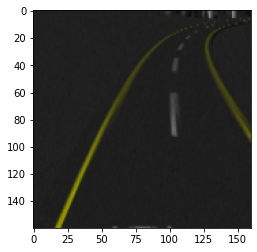

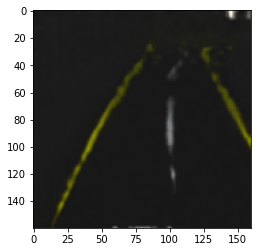

In [91]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import array_to_img
def plot_latent_space(trained_decoder, pimage, n=50, figsize=15):


    image = pimage[Config.data_collection['image_crop_y1']:Config.data_collection['image_crop_y2'],
                Config.data_collection['image_crop_x1']:Config.data_collection['image_crop_x2']]
    image = cv2.resize(image, 
                        (config['input_image_width'],
                        config['input_image_height']))
    image = np.array(image).astype("float32")/255.0
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    image = np.expand_dims(image, axis=0)
    # vel = np.array()


    X_tvel = np.array([14.5])
    X_tvel = np.expand_dims(X_tvel, axis=0)
    X_tstr = np.array([0.3])
    X_tvel = np.expand_dims(X_tstr, axis=0)
    X_ttime = np.array([0.1])
    X_tvel = np.expand_dims(X_ttime, axis=0)
    # print(X_tvel.shape)
    X_train = [image, X_tstr, X_tvel, X_ttime]

    x_encoded = VarAE.predict(X_train)*255.0
    # print(x_encoded)
    x_encoded_out = np.squeeze(x_encoded,axis=0)
    # pred_image = np.zeros([160,160,3], np.uint8)
    pred_image = array_to_img(x_encoded_out)
    pred_image = np.array(pred_image)
    pred_image = cv2.cvtColor(pred_image, cv2.COLOR_BGR2RGB)
    # pred_img = cv2.cvtColor(pred_image, cv2.COLOR_BGR2RGB)
    # print(type(pred_img))
    # print(pred_image.shape)
    plt.imshow(pred_image)
    # plt.imshow(cv2.cvtColor(pred_image, cv2.COLOR_BGR2RGB))
    plt.show()

    origin_image_name = '/home2/kdh/vae/vae_test/'+
    cv2.imwrite('/')
    # plt.xticks(pixel_range, sample_range_x)
    # plt.yticks(pixel_range, sample_range_y)
    # plt.xlabel("z[0]")
    # plt.ylabel("z[1]")

# test_img = cv2.imread('/home2/kdh/vae/2022-12-08-14-25-28/2022-12-08-14-30-12-332957.jpg')
# plot_latent_space(decoder, test_img)

In [115]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import array_to_img
def save_latent_space(trained_decoder, valid_data, n=50, figsize=15):
        
    for image_name, velocity, measurement, tar_image_name, tar_steering_angle, tar_vel, tar_time in valid_data:
        # self.data.image_names, self.data.velocities, self.data.measurements, 
        # self.data.tar_image_names, self.data.tar_steering_angle, self.data.tar_vel, self.data.tar_time
        
        image_path = data_path + '/' + image_name
        # print(data_path, tar_image_name)
        tar_image_path = data_path + '/' + tar_image_name
        image = cv2.imread(image_path)
        tar_image = cv2.imread(tar_image_path)

        # if collected data is not cropped then crop here
        # otherwise do not crop.
        image = image[Config.data_collection['image_crop_y1']:Config.data_collection['image_crop_y2'],
                    Config.data_collection['image_crop_x1']:Config.data_collection['image_crop_x2']]
        image = cv2.resize(image, 
                            (config['input_image_width'],
                            config['input_image_height']))
        tar_image = tar_image[Config.data_collection['image_crop_y1']:Config.data_collection['image_crop_y2'],
                    Config.data_collection['image_crop_x1']:Config.data_collection['image_crop_x2']]
        tar_image = cv2.resize(tar_image, 
                            (config['input_image_width'],
                            config['input_image_height']))

        cv2.imwrite('/home2/kdh/vae/vae_test/'+image_name, image)
        image = np.array(image).astype("float32")/255.0
        # image = image_process.process(image)
        steering_angle, throttle, brake = measurement
        
        image = np.expand_dims(image, axis=0)
        X_tvel = np.array([velocity])
        X_tvel = np.expand_dims(X_tvel, axis=0)
        X_tstr = np.array([steering_angle])
        X_tstr = np.expand_dims(X_tstr, axis=0)
        X_ttime = np.array([tar_time])
        X_ttime = np.expand_dims(X_ttime, axis=0)
        
        X_train = [image, X_tstr, X_tvel, X_ttime]

        x_encoded = VarAE.predict(X_train)*255.0
        x_encoded_out = np.squeeze(x_encoded,axis=0)
        pred_image = array_to_img(x_encoded_out)
        pred_image = np.array(pred_image)
        # pred_image = cv2.cvtColor(pred_image)
        # plt.imshow(pred_image)
        # plt.show()

        # image_name = '/home2/kdh/vae/vae_test/'+image_name
        pred_image_name = '/home2/kdh/vae/vae_test/'+image_name[:-4]+'_'+str(int(steering_angle*1000))+'_'+str(int(velocity))+'_'+str(tar_time)[:4]+'.jpg'
        gt_tar_image_name = '/home2/kdh/vae/vae_test/'+image_name[:-4]+'_'+str(int(steering_angle*1000))+'_'+str(int(velocity))+'_'+str(tar_time)[:4]+'_gt.jpg'
        cv2.imwrite(pred_image_name, pred_image)
        cv2.imwrite(gt_tar_image_name, tar_image)

        # print(pred_image_name,' done')
        # cv2.imwrite('/')


# save_latent_space(decoder, valid_data[3423:4422])

In [173]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import array_to_img
def save_latent_space_diff_steer(trained_decoder, pimage, save_image_name, n=50, figsize=15):


    image = pimage[Config.data_collection['image_crop_y1']:Config.data_collection['image_crop_y2'],
                Config.data_collection['image_crop_x1']:Config.data_collection['image_crop_x2']]
    image = cv2.resize(image, 
                        (config['input_image_width'],
                        config['input_image_height']))
    cv2.imwrite('/home2/kdh/vae/vae_diff_steer_test/'+save_image_name+'.jpg', image)
    image = np.array(image).astype("float32")/255.0
    # plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    # plt.show()
    image = np.expand_dims(image, axis=0)
    # vel = np.array()


    X_tvel = np.array([14.85])
    X_tvel = np.expand_dims(X_tvel, axis=0)
    X_ttime = np.array([0.8])
    X_ttime = np.expand_dims(X_ttime, axis=0)
    # print(X_tvel.shape)
    for s in np.arange(0, 0.8, 0.0125):
        X_tstr = np.array([s-0.4])
        X_tstr = np.expand_dims(X_tstr, axis=0)
        X_train = [image, X_tstr, X_tvel, X_ttime]

        x_encoded = VarAE.predict(X_train)*255.0
        x_encoded_out = np.squeeze(x_encoded,axis=0)
        pred_image = array_to_img(x_encoded_out)
        pred_image = np.array(pred_image)
        # pred_image = cv2.cvtColor(pred_image, cv2.COLOR_BGR2RGB)
        s_str = "{:.3f}".format(s)
        pred_image_name = ('/home2/kdh/vae/vae_diff_steer_test/'
                            +save_image_name
                            +'_'+str(s_str)
                            +'.jpg'
        )
        cv2.imwrite(pred_image_name, pred_image)
    
        

# test_img = cv2.imread('/home2/kdh/vae/2022-12-08-14-25-28/2022-12-08-14-35-43-708754.jpg')
# save_latent_space_diff_steer(decoder, test_img, '2022-12-08-14-35-43-708754')